In [1]:
### Imports for the Notebook

import numpy as np
import pandas as pd

import sys
import pickle

from fastai.vision.all import *
#from torchvision.prototype.models import resnet50
from utils import *
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
path_wiki = 'data/watches/ds1_kaggle/cleandata.csv'
path_imdb = 'data/watches/ds1_kaggle/images/'
img_size = 255

In [3]:
df = pd.read_csv(path_wiki, index_col=0)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=12)

In [4]:
data_imdb = ImageDataLoaders.from_df(df_train, path_imdb, cols=['Code'], folder ='.',item_tfms=Resize(img_size), y_block=RegressionBlock())

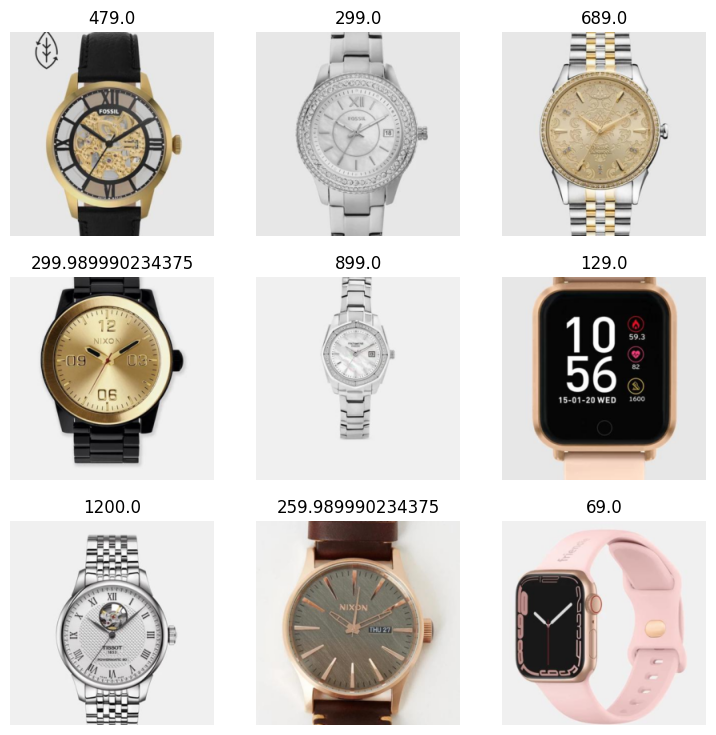

In [5]:
data_imdb.show_batch()

In [6]:
tst = AvgMetric(lambda x,y: (x-y).abs().mean())

In [7]:
#model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

In [8]:
learn = vision_learner(data_imdb, resnet34, metrics=tst)
learn.loss = MSELossFlat

/Users/hpe/Library/Caches/pypoetry/virtualenvs/watch-price-prediction-k7n7b7j3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hpe/Library/Caches/pypoetry/virtualenvs/watch-price-prediction-k7n7b7j3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0691830962896347)

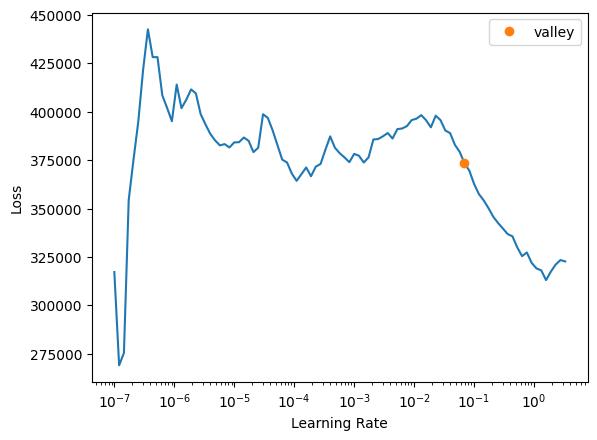

In [9]:
learn.lr_find()

In [10]:
learn.fine_tune(3, 3e-1)

epoch,train_loss,valid_loss,,time
0,235138.421875,151237.781250,405.631561,00:45


epoch,train_loss,valid_loss,,time
0,167930.046875,23701232.000000,4439.473633,06:38
1,149912.859375,1143576.000000,981.558838,05:37
2,130624.648438,106764.750000,356.803711,05:20


In [11]:
def get_predictions(df, image_path):
    example_test_watches = df["image_name"].values 
    example_test_price = df["price"].values 

    predictions = []
    for watch in example_test_watches:
        predictions.append(int(learn.predict(str(image_path) + "/" + watch)[1]))
        
    return predictions, example_test_price

In [12]:
y_pred, y_test = get_predictions(df_test, path_imdb);
y_pred_train, y_train = get_predictions(df_train, path_imdb);

In [16]:
print(f"The R2 score of the model on the Test Data is: {r2_score(y_test, y_pred)}")
print(f"The R2 score of the model on the Train Data is: {r2_score(y_train, y_pred_train)}")

The R2 score of the model on the Test Data is: 0.23437417426829166
The R2 score of the model on the Train Data is: 0.4586529941480372


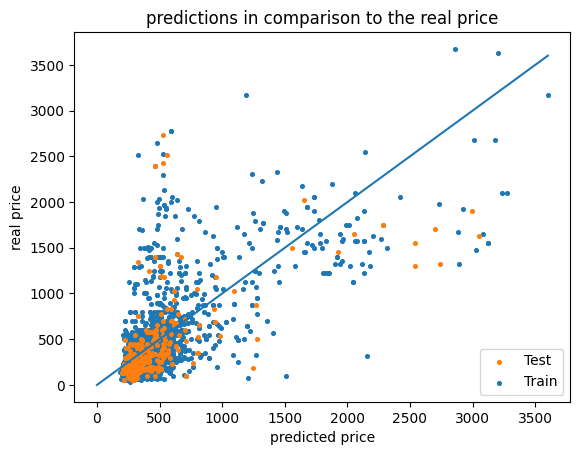

In [17]:
fig, ax = plt.subplots()

train = ax.scatter(y_pred_train, y_train, s=7, label ="Train")
test = ax.scatter(y_pred, y_test, s=7, label= "Test")

ax.plot([0,max(y_pred_train)], [0,max(y_pred_train)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test, train], loc='lower right')

plt.show()

In [17]:
## save model to storage
import dill
serialized_function = dill.dumps(learn)

with open("models/M3_RN_ds1.pickle", mode="wb") as out_file:
    pickle.dump(serialized_function, out_file)

## Test Model on other Dataset

In [18]:
ds2_path_wiki = 'data/watches/ds2_marc/cleandata.csv'
ds2_path_imdb = 'data/watches/ds2_marc/images/'

In [19]:
df_ds2 = pd.read_csv(ds2_path_wiki, index_col=0)

In [20]:
y_pred_ds2, all_label_ds2 = get_predictions(df_ds2, ds2_path_imdb);

/Users/hpe/Library/Caches/pypoetry/virtualenvs/watch-price-prediction-k7n7b7j3-py3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [21]:
print(f"The R2 score on the Marc Gebauer Data is: {r2_score(all_label_ds2, y_pred_ds2)}")

The R2 score on the Marc Gebauer Data is: -0.31309157910972685


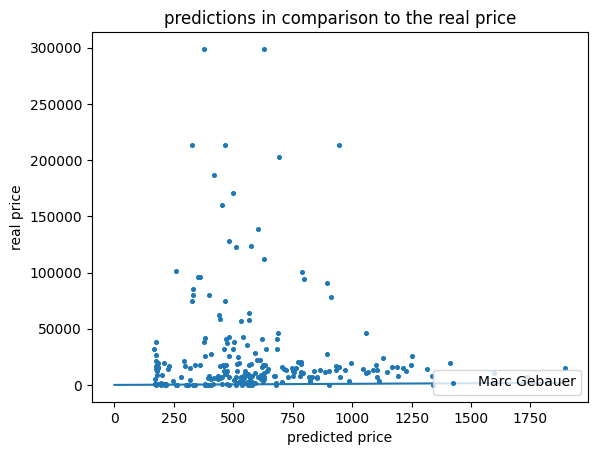

In [22]:
fig, ax = plt.subplots()

test = ax.scatter(y_pred_ds2, all_label_ds2, s=7, label ="Marc Gebauer")

ax.plot([0,max(y_pred_ds2)], [0,max(y_pred_ds2)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test], loc='lower right')

plt.show()

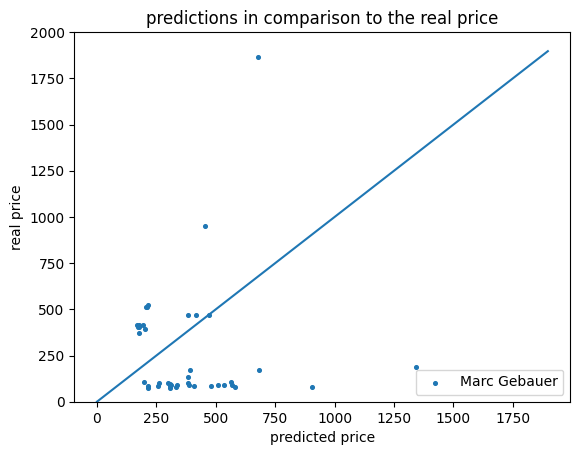

In [23]:
fig, ax = plt.subplots()

test = ax.scatter(y_pred_ds2, all_label_ds2, s=7, label ="Marc Gebauer")

ax.plot([0,max(y_pred_ds2)], [0,max(y_pred_ds2)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test], loc='lower right')

ax.set_ylim(0, 2000)  

plt.show()